The objective of this project is indicated in the website:  
"Egis contribue à l’exploitation du contrôle du stationnement sur voirie pour plusieurs villes, en France et à l’international.
Des véhicules équipés de caméras prennent des photos des véhicules stationnés.
Puis, à partir du numéro de la plaque, de la géolocalisation et de l’horodatage, un processus est initié pour contrôler la validité du stationnement et aller jusqu’à l’émission d’un forfait post stationnement si nécessaire. 
Nous sommes convaincus que l’analyse de ces données permettrait d’optimiser l’activité d’exploitation d’une part et permettrait de réduire le taux d’infraction constaté.
Nous suggérons donc de mettre au point un modèle de Machine Learning dans le but d’Identifier les zones / horaires où il y a le plus d’infractions et optimiser les trajets des véhicules de contrôle du stationnement en conséquence."

# Import Libraries

In [28]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns

In [90]:
# Split datasets into features (X) and target (y)
X_train = pd.read_csv('x_train_final_asAbTs5.csv', sep=',', header=0, encoding='utf-8') # (4861236, 11)
y_train = pd.read_csv('y_train_final_YYyFil7.csv', sep=',', header=0, encoding='utf-8') # (2028750, 11)
X_test = pd.read_csv('x_test_final_fIrnA7Q.csv', sep=',', header=0, encoding='utf-8') # (4861236, 2)

# Handling of Na values
In the X Train data, there are Na values to handle in the "HauteurNeige" and "ForceVent" variables.
In the Y test data, there are Na values in the HauteurNeige variables.

In [49]:
print("X train data\n", X_train.isnull().sum()) # Check for missing values in X_train. HauteurNeige contains 1314641 missing values while ForceVent contains 4888 missing values.
print("X test data\n", X_test.isnull().sum()) # Check for missing values in X_test. HauteurNeige contains 7906 missing values.
print("Y train data\n", y_train.isnull().sum())


X train data
 Unnamed: 0               0
total_count              0
longitude_scaled         0
latitude_scaled          0
Precipitations           0
HauteurNeige        131461
Temperature              0
ForceVent             4888
day_of_week              0
month_of_year            0
hour                     0
dtype: int64
X test data
 Unnamed: 0             0
total_count            0
longitude_scaled       0
latitude_scaled        0
Precipitations         0
HauteurNeige        7906
Temperature            0
ForceVent              0
day_of_week            0
month_of_year          0
hour                   0
dtype: int64
Y train data
 Unnamed: 0       0
invalid_ratio    0
dtype: int64


Text(0.5, 1.0, 'Matrice de corrélation')

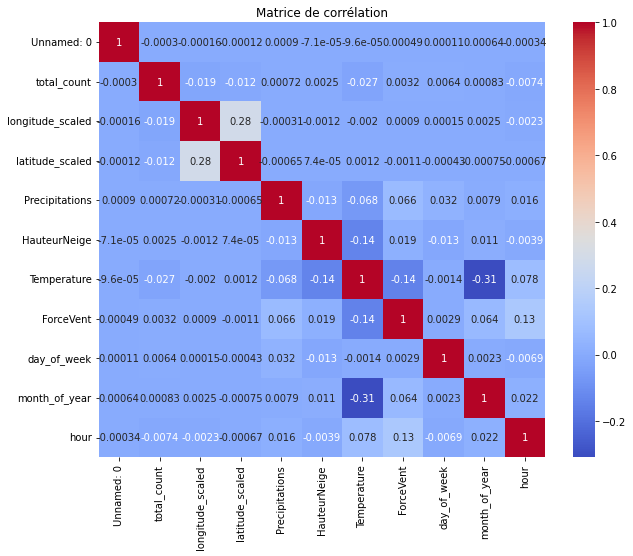

In [29]:
plt.figure(figsize=(10,8))
sns.heatmap(X_train.corr(), annot=True, cmap='coolwarm')
plt.title("Matrice de corrélation")


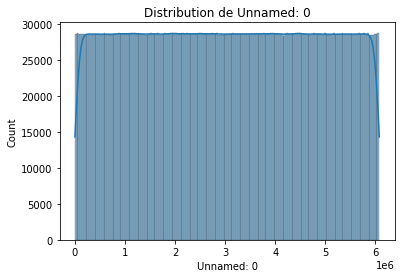

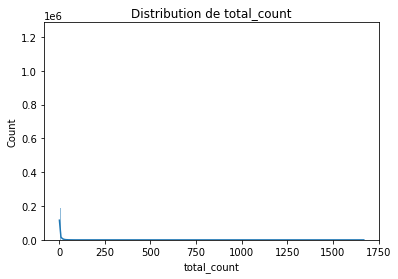

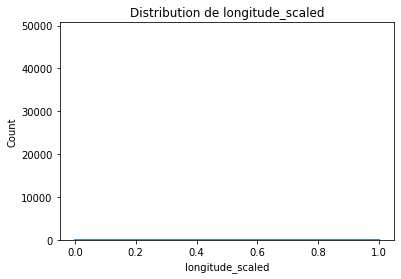

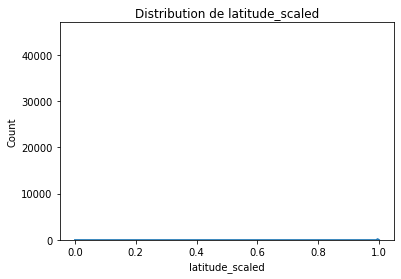

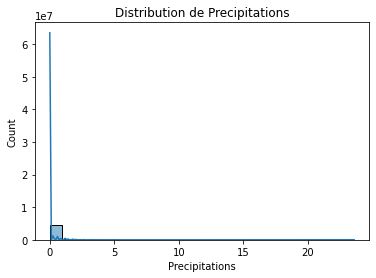

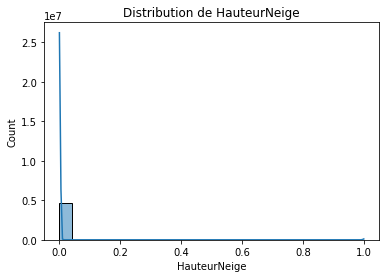

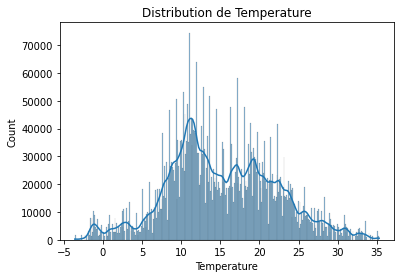

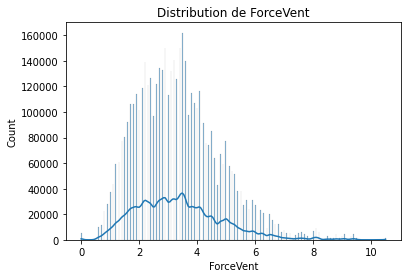

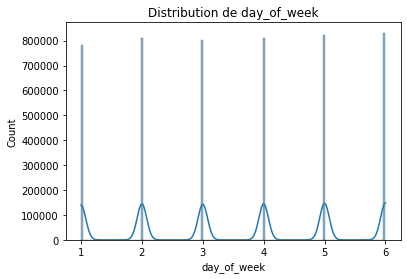

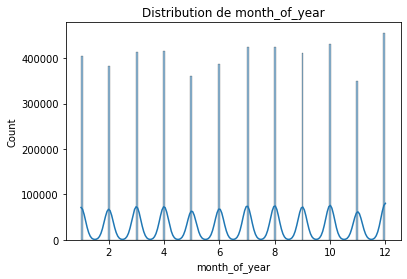

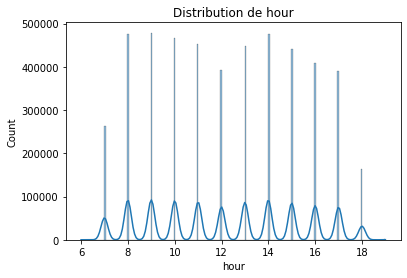

In [44]:
%%script python -c "pass"
import matplotlib.pyplot as plt
import seaborn as sns

for col in X_train.select_dtypes(include='number').columns:
    plt.figure()
    sns.histplot(X_train[col].dropna(), kde=True)
    plt.title(f'Distribution de {col}')


for col in X_train.select_dtypes(include='object').columns:
    plt.figure()
    X_train[col].value_counts().plot(kind='bar')
    plt.title(f'Valeurs de {col}')


In [91]:
X_train["hour_sin"] = np.sin(2 * np.pi * X_train["hour"] / 24)
X_train["hour_cos"] = np.cos(2 * np.pi * X_train["hour"] / 24)
X_train["is_weekend"] = X_train["day_of_week"] >= 5

X_test["hour_sin"] = np.sin(2 * np.pi * X_test["hour"] / 24)
X_test["hour_cos"] = np.cos(2 * np.pi * X_test["hour"] / 24)
X_test["is_weekend"] = X_test["day_of_week"] >= 5

# Méthode du coude

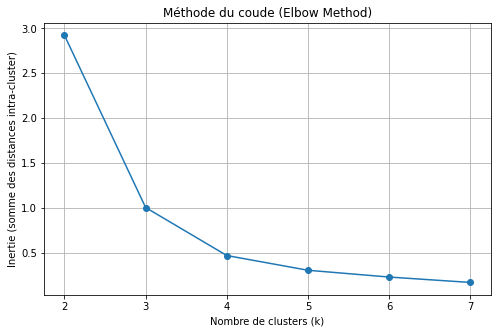

In [37]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

X = X_train[["latitude_scaled", "longitude_scaled"]]  # ou d'autres colonnes géo
inertias = []
K_range = range(2, 8)  # à adapter selon tes données

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

# Tracer la courbe
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertias, marker='o')
plt.title("Méthode du coude (Elbow Method)")
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Inertie (somme des distances intra-cluster)")
plt.grid(True)
plt.show()


In [92]:
from sklearn.cluster import KMeans

number_cluster = 4

X_tr = X_train[["latitude_scaled", "longitude_scaled"]]
kmeans = KMeans(n_clusters=number_cluster)
X_train["geo_cluster"] = kmeans.fit_predict(X_tr)

X = X_test[["latitude_scaled", "longitude_scaled"]]
kmeans = KMeans(n_clusters=number_cluster)
X_test["geo_cluster"] = kmeans.fit_predict(X)


In [98]:
X_train.loc[X_train["Temperature"] > 5 & X_train["HauteurNeige"].isna(), "HauteurNeige"] = 0
X_train.loc[X_train["HauteurNeige"].isna()] = 1.0

X_test.loc[X_test["Temperature"] > 5 & X_test["HauteurNeige"].isna(), "HauteurNeige"] = 0
X_test.loc[X_test["HauteurNeige"].isna()] = 1.0

# X_train[(X_train["month_of_year"] == 12) & (X_train["day_of_week"] == 1) & (X_train["hour"] >= 8) & (X_train["hour"] <= 10)]

# X_train[X_train["ForceVent"].isna()]

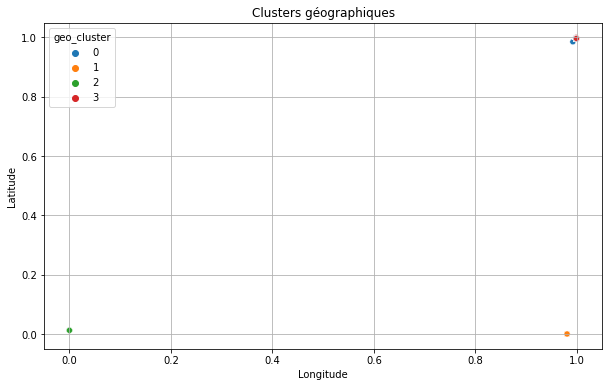

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.scatterplot(data=X_train, x="longitude_scaled", y="latitude_scaled", hue="geo_cluster", palette="tab10")
plt.title("Clusters géographiques")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

In [99]:
features = [
    'Precipitations', 'HauteurNeige', 'Temperature', 'ForceVent',
    'hour_sin', 'hour_cos', 'is_weekend', 'geo_cluster'
]
X = X_train[features]
y = y_train['invalid_ratio']  # adapte si ton nom est différent
X_test_final = X_test[features]


In [101]:
# Handle missing or invalid values
X_train = X_train.replace([np.inf, -np.inf], np.nan).dropna()
# y_train = y_train.replace([np.inf, -np.inf], np.nan).dropna()
X_test = X_test.replace([np.inf, -np.inf], np.nan).dropna()

# Ensure alignment between X_train and y_train after dropping rows
X_train, y_train = X_train.align(y_train, join='inner', axis=0)

In [ ]:
print("X train data\n", X_train.isnull().sum()) # Check for missing values in X_train. HauteurNeige contains 1314641 missing values while ForceVent contains 4888 missing values.
print("X test data\n", X_test.isnull().sum()) # Check for missing values in X_test. HauteurNeige contains 7906 missing values.
print("Y train data\n", y_train.isnull().sum())


In [102]:
from sklearn.model_selection import cross_val_score
import scipy.stats as stats
from sklearn.metrics import make_scorer

# Définir un scorer basé sur spearmanr
def spearman_scorer(y_true, y_pred):
    return spearmanr(y_true, y_pred).correlation  # retourne juste le coef

# Le transformer en scorer utilisable par scikit-learn
spearman_score = make_scorer(spearman_scorer, greater_is_better=True)

# Train RandomForest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
scores = cross_val_score(model, X, y, cv=5, scoring=spearman_score)

print("Score Spearman moyen (CV) :", scores.mean())

c:\Users\leona\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\leona\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\leona\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 304, in fit
    X, y = self._validate_data(X, y, multi_output=True,
  File "c:\Users\leona\anaconda3\lib\site-packages\sklearn\base.py", line 433, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "c:\Users\leona\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "c:\Users\leona\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 871, in check_X_y
    X = check_array(X, accept_sparse=accept_spars

Score Spearman moyen (CV) : nan


c:\Users\leona\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\leona\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\leona\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 304, in fit
    X, y = self._validate_data(X, y, multi_output=True,
  File "c:\Users\leona\anaconda3\lib\site-packages\sklearn\base.py", line 433, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "c:\Users\leona\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "c:\Users\leona\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 871, in check_X_y
    X = check_array(X, accept_sparse=accept_spars

In [103]:
model.fit(X_train, y_train.values)  # Flatten y_train if it's a single column

# Predict on test set
y_pred = model.predict(X_test)

MemoryError: could not allocate 469762048 bytes

In [ ]:
# Ensuite tu sauves pour soumettre si besoin
pd.DataFrame({"prediction": y_pred_test}).to_csv("submission.csv", index=False)

In [ ]:
# Ensure alignment between y_test and y_pred
y_test = y_test.iloc[:len(y_pred)]
spearman_corr, _ = spearmanr(y_test.values, y_pred)

print(f"Spearman Correlation: {spearman_corr}")
